In [26]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from _cpp import *

## Visual Check

In [27]:
def inclusion_prob(p):
    second_order = (p/(1-p)).sum() - p/(1-p)
    return p * (1.0 + second_order)/2

def second_inclusion_prob(p):
    second_order = (p/(1-p)).sum() - p/(1-p)
    tmp = (p.unsqueeze(1) @ p.unsqueeze(1).T) / \
        ((torch.ones(N, N) - p.unsqueeze(1) - p.unsqueeze(0)) *
        (torch.ones(N, N) - p.unsqueeze(1)))
    third_order =  tmp.sum() - tmp.sum(dim=1) - tmp.sum(dim=0) - \
                torch.diag(tmp).sum() + 2 * torch.diag(tmp)

    return p * (1.0 + second_order + third_order)/3

def optimal_prob(weights, eps):
    N = len(weights)

    sorted_weights, perm = weights.sort(descending=True)[:]
    inv_perm = torch.argsort(perm)
    cumsums = sorted_weights.cumsum(dim=0)

    comparators = eps * cumsums/(1 - (N - torch.arange(1, N+1)) * eps)
    r_star = torch.nonzero(sorted_weights >= comparators, as_tuple=False)[-1]
    s_star = cumsums[r_star]
    c_star = 1 - (N - r_star - 1) * eps
    nc = cumsums[r_star]/(1 - (N - r_star - 1) * eps)
    ordered_p = torch.cat([sorted_weights[0:(r_star+1)]/nc, 
                           eps * torch.ones(N - r_star - 1)])
    return ordered_p[inv_perm]


In [28]:
N = 10
k = 5
T = int(1e05)

bernoullis = torch.empty(T, dtype=torch.bool)
uniforms = torch.empty(T, dtype=torch.float64)
indices = torch.empty(T, dtype=torch.int64)
probs = torch.empty(T, dtype=torch.float64)

p_b = 0.75
eps = 1/(2*N) * torch.rand(1).item()
weights = torch.rand(N, dtype=torch.float64)

p = weights/weights.sum()
inc_p = inclusion_prob(p)
inc_inc_p = second_inclusion_prob(p)

p_mix = p_b * p + (1.0 - p_b)/N

p_opt = optimal_prob(weights, eps)
inc_p_opt = inclusion_prob(p_opt)
inc_inc_p_opt = second_inclusion_prob(p_opt)

### Uniform (only supports without replacement)

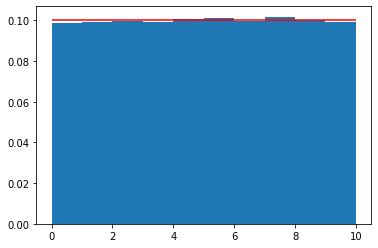

In [4]:
k = 5
sampler = UniformSampler(N)
uniforms.uniform_()
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))])
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=1/N, xmin=i, xmax=i+1, colors="red")
plt.show()

### Weighted

In [5]:
sampler = WeightedSampler(weights)
uniforms.uniform_();

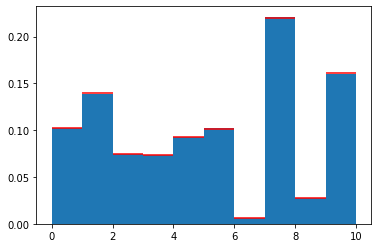

In [6]:
# with replacement
k=5
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], replace=True)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=p[i], xmin=i, xmax=i+1, colors="red")
plt.show()

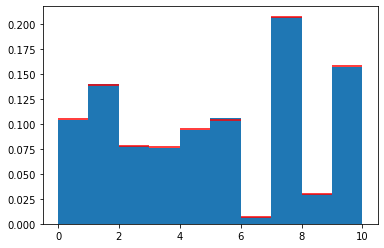

In [7]:
# without replacement (k=2)
k = 2
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], replace=False)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=inc_p[i], xmin=i, xmax=i+1, colors="red")
plt.show()

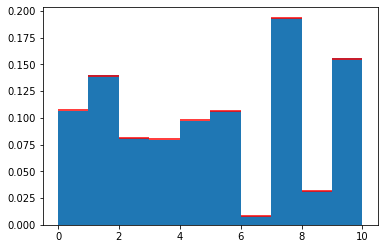

In [8]:
# without replacement (k=3)
k = 3
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], replace=False)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=inc_inc_p[i], xmin=i, xmax=i+1, colors="red")
plt.show()

### Weighted Uniform Mixture (only supports sampling with replacement)

In [11]:
sampler = WeightedUniformSampler(weights)
bernoullis.bernoulli_(p_b)
uniforms.uniform_();

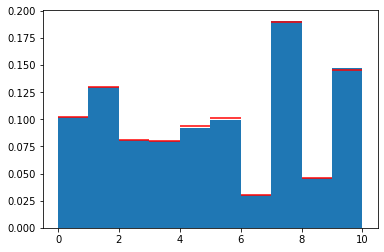

In [12]:
k=5
for i in range(T // k):
    sampler.sample(bernoullis[k*i:(k*(i+1))], uniforms[k*i:(k*(i+1))], 
                   indices[k*i:(k*(i+1))], probs[k*i:(k*(i+1))], 
                   p_b)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=p_mix[i], xmin=i, xmax=i+1, colors="red")
plt.show()

### Optimal

In [29]:
sampler = OptimalSampler(weights)
uniforms.uniform_();

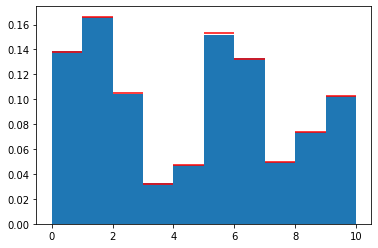

In [30]:
# with replacement
k=5
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], True,
                   eps, False)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=p_opt[i], xmin=i, xmax=i+1, colors="red")
plt.show()

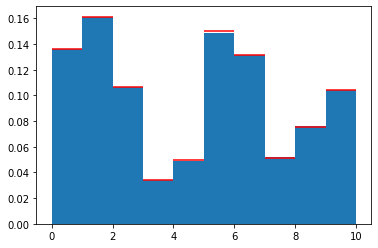

In [31]:
# without replacement (k=2)
k=2
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], False,
                   eps, False)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=inc_p_opt[i], xmin=i, xmax=i+1, colors="red")
plt.show()

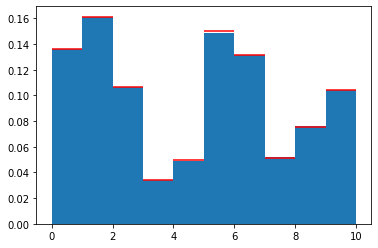

In [32]:
# without replacement + delete (k=2)
k=2
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], False,
                   eps, True)
    sampler.update(indices[k*i:(k*(i+1))], weights[indices[k*i:(k*(i+1))]])
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=inc_p_opt[i], xmin=i, xmax=i+1, colors="red")
plt.show()

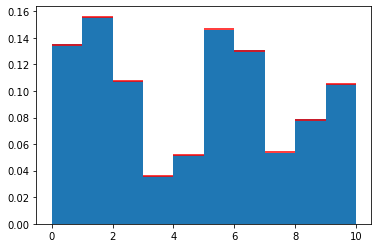

In [33]:
# without replacement (k=3)
k=3
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], False,
                   eps, False)
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=inc_inc_p_opt[i], xmin=i, xmax=i+1, colors="red")
plt.show()

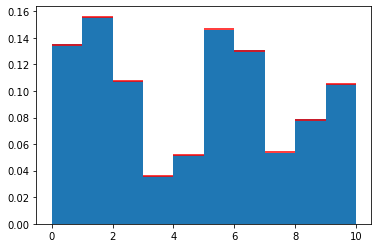

In [34]:
# without replacement + delete (k=3)
k=3
for i in range(T // k):
    sampler.sample(uniforms[k*i:(k*(i+1))], indices[k*i:(k*(i+1))],
                   probs[k*i:(k*(i+1))], False,
                   eps, False)
    sampler.update(indices[k*i:(k*(i+1))], weights[indices[k*i:(k*(i+1))]])
plt.hist(indices, bins=list(range(N+1)), density=True)
for i in range(N):
    plt.hlines(y=inc_inc_p_opt[i], xmin=i, xmax=i+1, colors="red")
plt.show()

## Performance

In [18]:
N = int(1e05)
S = int(100)
eps = 1/(2*N) * torch.rand(1).item()

weights = torch.rand(N, dtype=torch.float64)
np.weights = weights.numpy()

bernoullis = torch.empty(S, dtype=torch.bool)
uniforms = torch.empty(S, dtype=torch.float64)
indices = torch.empty(S, dtype=torch.int64)
probs = torch.empty(S, dtype=torch.float64)

In [19]:
%%timeit us=UniformSampler(N)

uniforms.uniform_()
us.sample(uniforms.numpy(), indices.numpy())

5.87 µs ± 63.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
%%timeit ws=WeightedSampler(weights)

uniforms.uniform_()
ws.sample(uniforms.numpy(), indices.numpy(), probs.numpy(), replace=False)

25.6 µs ± 855 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
%%timeit wus=WeightedUniformSampler(weights)

uniforms.uniform_()
p_b = torch.rand(1).item()
bernoullis.bernoulli_(p_b)
wus.sample(bernoullis.numpy(), uniforms.numpy(), 
           indices.numpy(), probs.numpy(),
           p_b)

28.9 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%%timeit os=OptimalSampler(weights)

uniforms.uniform_()
eps = torch.rand(1).item() * 1/(2*N) 
os.sample(uniforms.numpy(), indices.numpy(), probs.numpy(), False, eps, False)

145 µs ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
%%timeit os=OptimalSampler(weights)

uniforms.uniform_()
eps = torch.rand(1).item() * 1/(2*N) 
os.sample(uniforms.numpy(), indices.numpy(), probs.numpy(), False, eps, False)
os.update(indices.numpy(), uniforms.numpy())

299 µs ± 7.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
